In [45]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D, Add, MaxPooling2D, Dense, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
class_names = ['Cat', 'Dog']

n_dogs = len(os.listdir('PetImages/Dog'))
n_cats = len(os.listdir('PetImages/Cat'))

In [47]:
n_images = [n_cats, n_dogs]
px.pie(class_names, n_images)

In [48]:
def clear_tmp_folder(tmp_dir):
    if os.path.exists(tmp_dir):
        for filename in os.listdir(tmp_dir):
            file_path = os.path.join(tmp_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(e)

    else:
        print('Does not exists')

clear_tmp_folder('/tmp')

In [49]:
# tmp 디렉토리 : 운영체제에서 제공하는 !임시 디렉토리!
base_dir = '/tmp/cats-v-dogs'
training_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [50]:
dirs = [
    base_dir,
    training_dir, os.path.join(training_dir, 'cats'), os.path.join(training_dir, 'dogs'),
    validation_dir, os.path.join(validation_dir, 'cats'), os.path.join(validation_dir, 'dogs'),
    test_dir, os.path.join(test_dir, 'cats'), os.path.join(test_dir, 'dogs')
]

In [51]:
# os.makedirs
for dir in dirs:
    if not os.path.exists(dir):
        try:
            os.makedirs(dir)
        except OSError:
            print(f'Error Failed to make Directory : {dir}')

In [52]:
CAT_DIR = 'PetImages/Cat'
DOG_DIR = 'PetImages/Dog'

Training_DIR = '/tmp/cats-v-dogs/training/'
Validation_DIR = '/tmp/cats-v-dogs/validation/'

Training_CAT = os.path.join(Training_DIR, 'cats/')
Validation_CAT = os.path.join(Validation_DIR, 'cats/')

Training_DOG = os.path.join(Training_DIR, 'dogs/')
Validation_DOG = os.path.join(Validation_DIR, 'dogs/')

In [53]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

0
0
0
0
0
0


In [54]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split=True, split_size=0.9):
    # main_dir, training_dir, validation_dir, test_dir 네 가지의 디렉토리 경로가 존재한다.
    # include_test_split : 테스트 데이터셋을 포함할지 여부
    files = [] # 파일을 저장할 빈 리스트 생성
    for file in os.listdir(main_dir): # 메인 디렉토리 내부 파일을 모두 가져오겠다.(반복문)
        if os.path.getsize(os.path.join(main_dir, file)): # getsize : 파일 크기가 0이 아닌 파일들
            files.append(file) # 모든 이미지들을 files에 넣어준다.

    shuffled_files = random.sample(files, len(files)) # 파일을 랜덤하게 섞어주고
    split = int(0.9 * len(shuffled_files)) # 0.9% 기준으로 파일 사이즈를 나누어준다.(10:90)
    train = shuffled_files[:split] # 90%의 데이터는 train에 넣어놓겠다.
    split_valid_test = int(split + (len(shuffled_files) - split)/2) 
    # 검증 데이터와 테스트 데이터를 나누는(split 이후 가장 마지막까지 접근하였을 때)(10%)
    # split : 전체에서 90%, shuffled_files : 전체 데이터
    # 전체 길이 - split 데이터 = 나머지 10%
    # split + ==> split 다음부터 보겠다.
    # /2 ==> 10% 남아있는 데이터를 절반으로 나누겠다. == split_valid_test

    if include_test_split: # 조건문 / test_split을 포함한다면,
        validation = shuffled_files[split:split_valid_test]
        # 10% 나눈 구간의 앞부분(첫 부분)(validation에 저장)
        test = shuffled_files[split_valid_test:]
        # 10% 나눈 구간의 뒷부분(두 번째 부분)(test에 저장)
        # true인 경우 -> validation(5%) & test(5%)
    else: # 만약 포함하지 않는다면
        validation = shuffled_files[split:] # 검증데이터로 그냥 넣어달라.

    for element in train:
        copyfile(os.path.join(main_dir, element), os.path.join(training_dir, element))
        # 해당하는 요소를 지정 디렉토리에 복사

    for element in validation:
        copyfile(os.path.join(main_dir, element), os.path.join(validation_dir, element))

    if include_test_split: # 만약 test_split을 가져오는게 true라면,
        for element in test:
            copyfile(os.path.join(main_dir, element), os.path.join(test_dir, element))

    print('Split Successful')

In [55]:
split_data(CAT_DIR, '/tmp/cats-v-dogs/training/cats', '/tmp/cats-v-dogs/validation/cats', '/tmp/cats-v-dogs/test/cats', True, 0.9)
split_data(DOG_DIR, '/tmp/cats-v-dogs/training/dogs', '/tmp/cats-v-dogs/validation/dogs', '/tmp/cats-v-dogs/test/dogs', True, 0.9)

Split Successful
Split Successful


In [56]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

11249
11249
625
625
625
625


In [57]:
train_gen = ImageDataGenerator(rescale=1./255)
validation_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

In [58]:
# flow_from_directory() : Keras의 이미지 데이터 생성기 기능(저장된 이미지 활용)
# 1. 디렉토리 구조 활용 : 자동으로 디렉토리를 인식하여 구조를 활용할 수 있다.
# 2. 데이터 증강 : 이미지 데이터 증식 기능을 제공한다.
# 3. 배치 처리 : 지정된 배치 크기에 따라 이미지를 효율적으로 불러올 수 있다.
# 4. 정규화 : 지정된 크기로 조정이 가능하며 픽셀 값을 정규화하여 모델 학습처리를 돕는다.
train_generator = train_gen.flow_from_directory('/tmp/cats-v-dogs/training', # 경로(파일명)
                                                target_size = (150, 150), # 데이터 증강
                                                batch_size=64, # 배치 사이즈
                                                class_mode = 'binary') # 이진분류 처리 

validation_generator = validation_gen.flow_from_directory('/tmp/cats-v-dogs/validation',
                                                target_size = (150, 150),
                                                batch_size=64, 
                                                class_mode = 'binary')

test_generator = test_gen.flow_from_directory('/tmp/cats-v-dogs/test',
                                                target_size = (150, 150),
                                                batch_size=64, 
                                                class_mode = 'binary')

Found 22498 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.


In [59]:
class_names = ['Cat', 'Dog']

def plot_data(generator, n_images):
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(15, 15))

    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

In [60]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

11249
11249
625
625
625
625


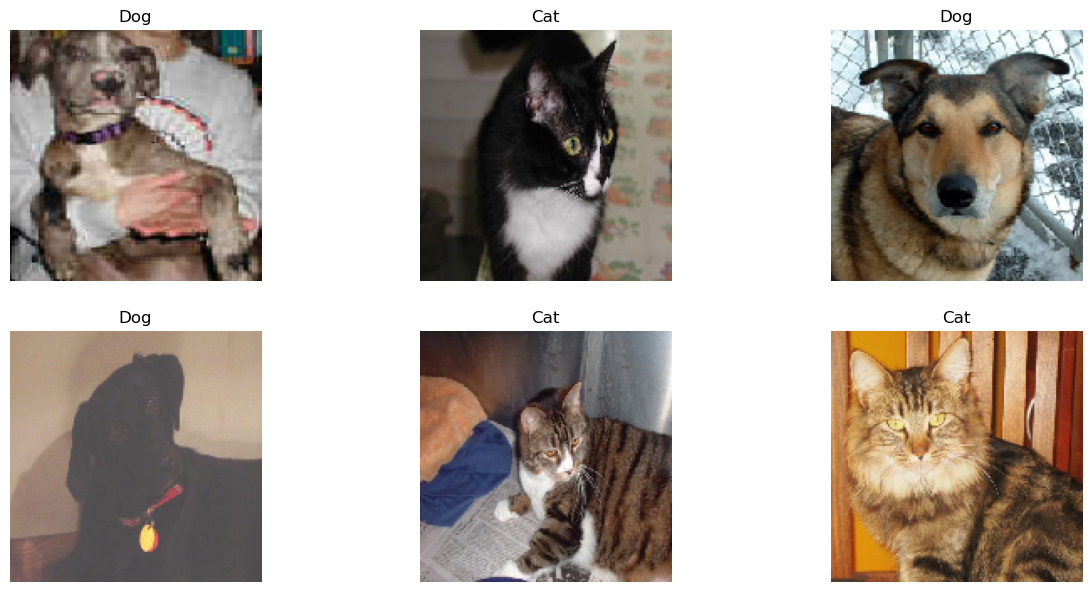

In [61]:
plot_data(train_generator, 7)

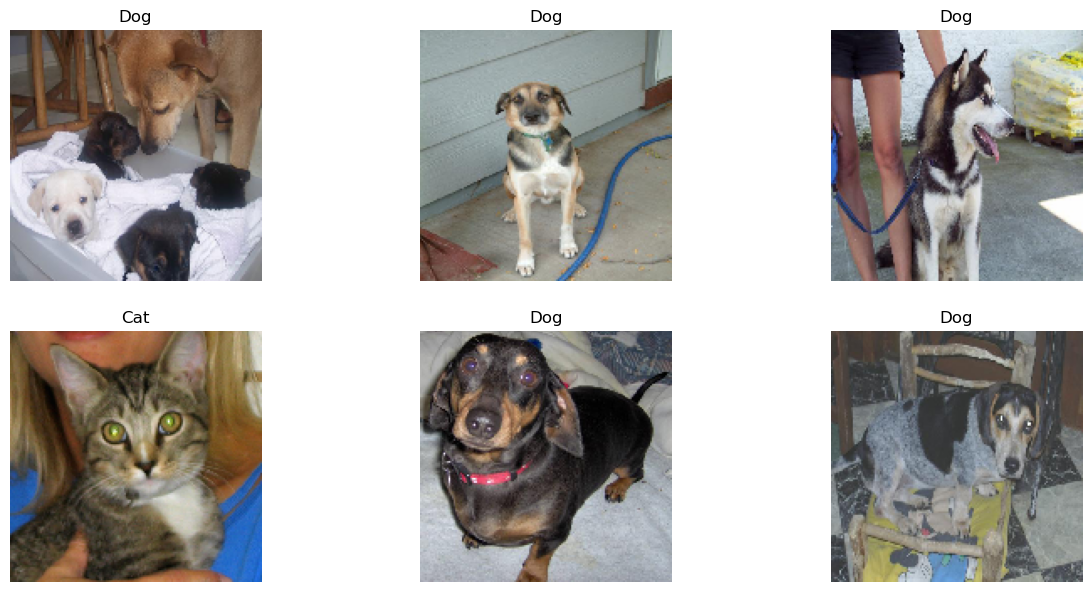

In [62]:
plot_data(train_generator, 7)

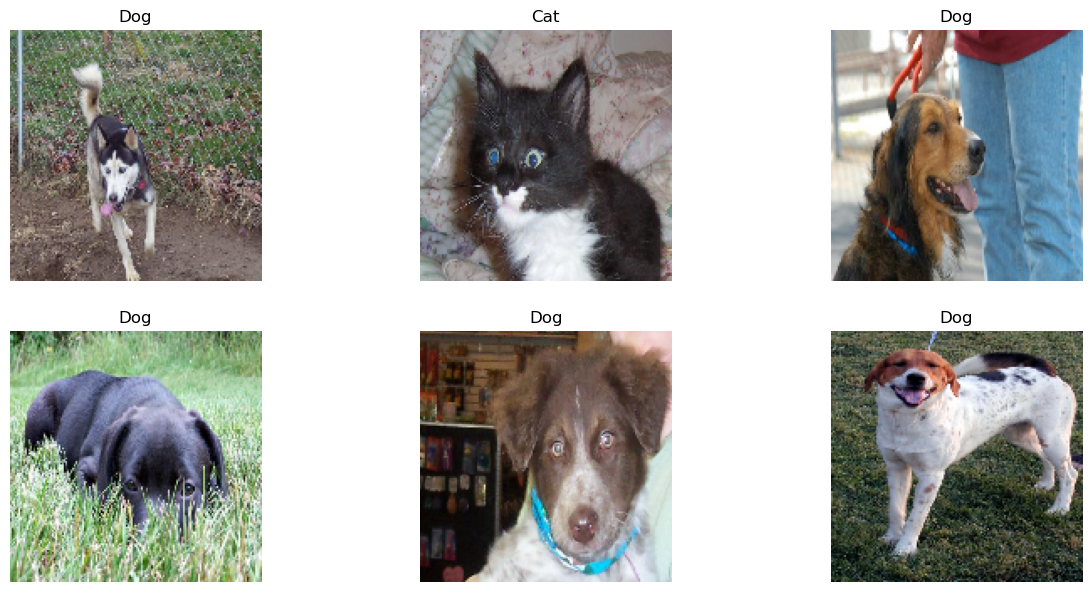

In [63]:
plot_data(validation_generator, 7)

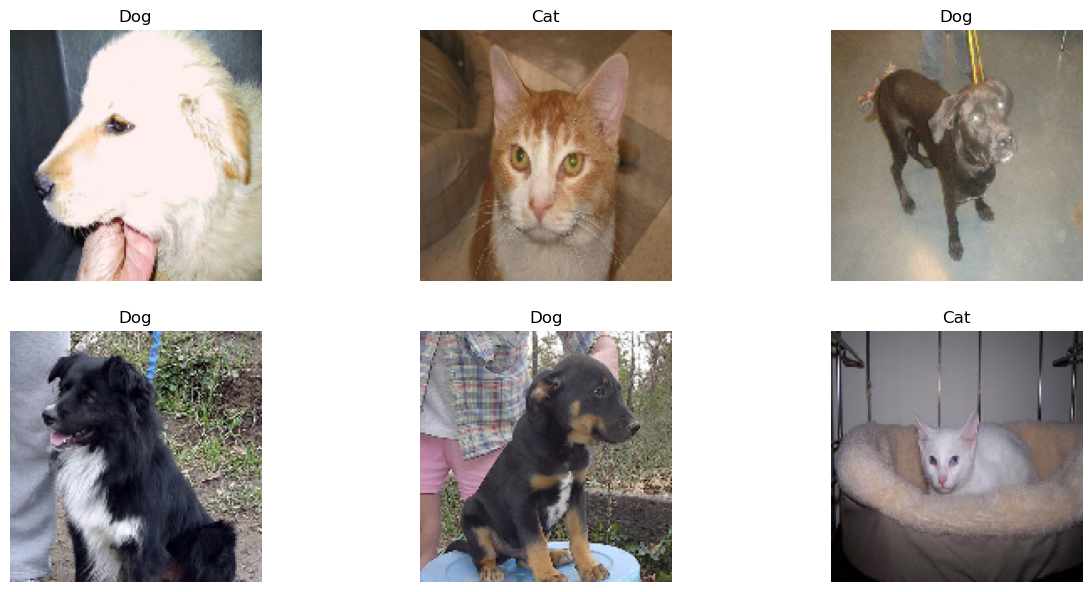

In [64]:
plot_data(test_generator, 7)

In [65]:
# 입력값을 (150, 150, 3)
inputs = tf.keras.layers.Input(shape=(150, 150, 3))
# conv2D 32, (3, 3), relu
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
# conv2D 64, (3, 3), relu
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
# MaxPooling (2, 2)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

# conv2D 64, (3, 3), relu
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
# conv2D 128, (3, 3), relu
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
# MaxPooling (2, 2)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

# conv2D 128, (3, 3), relu
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
# conv2D 256, (3, 3), relu
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)

# 전역 평균 풀링
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# 완전 연결층 1024, relu
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# 완전 연결층 2, softmax
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)                       

In [66]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), 
              loss = 'spare_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
r = model.fit(train_generator, epochs=10, validation_data=validation_generator)

# 모델을 저장합니다. (HDF5 형식 사용)
model.save('cats_dogs.h5')

Epoch 1/10
137/352 [==========>...................] - ETA: 21:42 - loss: 0.6876 - accuracy: 0.4564

/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:858: UserWarning:

Truncated File Read



352/352 [==============================] - 2197s 6s/step - loss: 0.6850 - accuracy: 0.4695 - val_loss: 0.6712 - val_accuracy: 0.2528
Epoch 2/10
352/352 [==============================] - 2228s 6s/step - loss: 0.6385 - accuracy: 0.5173 - val_loss: 0.6213 - val_accuracy: 0.3296
Epoch 3/10
290/352 [=======================>......] - ETA: 6:28 - loss: 0.5792 - accuracy: 0.5440

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('cats_dogs.h5')
r.save('cats_daogs.h5')

In [ ]:
model.evaluate(test_generator)

In [ ]:
def plot_prediction(generatorm n_images):
    i = 1
    images, labels = generator.next()

    preds = model.predict(images)
    # print(preds) # 고양이, 강아지 각각으로 예측할 확률
    predictions = np.agrmax(preds, axis=1)
    print(predictions) # 둘 중 너 높은 걸 가져와서 출력을 하겠다.(0 : 고양이, 1 : 강아지)
    labels = labels.astype('int32')
    # for label in lables: # 라벨에는 고양이일지 강아지일지 숫자로 저장되어 있다.
        # print(class_names[labels]) # class_names을 통해서 텍스트로 출력이 가능하다.
    plt.figure(figsize=(14, 15))
    for image, label in zip(image, labels):
        plt.subplot(4, 3, i) # 1~9
        plt.imshow(image)
        # print(label, labels[i-1]
        
        if predictions[i-1] == labels[i-1]: # 정답
            title = plt.title(class_names[label])
            plt.setp(title, color='g')
            plt.axis('off')
            
        else : # 오답
            title = plt.title(class_names[prediction[i-1]]) 무엇을 틀렸는지
            plt.setp(title, color='r')
            plt.axis('off')
        
        if i == n_images:
            break

    plt.show()

In [ ]:
plot_prediction(test_generator, 9)

In [ ]:
plot_prediction(validation_generator, 9)

In [ ]:
model.summary()

In [ ]:
# 활성화 맵 시각화

# 첫 번째 Dense Layer
gp_weights = model.get_layer('dense_2').get_weights()[0] # dense_2 레이어의 가중치 값을 가져온다.
# dense_2 ==> 이런 내용들은 'model.summary()를 통해 이름 확인하고 넣어야 한다.
# 마지막 Conv2D, akwlakr Dense Layer
activation_model = Model(model.inputs, outputs=(model.get_layer('conv2d_13').output, model.get_layers('dense_3').output)) 

In [ ]:
images, _ = test_generator.next()
features, results = activation_model.predict(images)

In [ ]:
def show_cam(image_index, features, results): # features : 추출된 특징, results : 모델의 예측
    # 선택된 이미지의 특징(중간 레이어에 대한 출력 특징)
    features_for_img = features[image_index, :, :, :]
    # 확률이 제일 높은 값 찾아주기
    prediction = np.argmax(results[images_index])
    # 예측에서의 갭 가중치를 구한다.(위에서 저장된 Dense_2 레이어의 가중치)
    class_activation_weights = gp_weights[:, prediction]
    # 이미지 크기 업 샘플링
    class_activation_features = sp.ndimage.zoom(features_for_img, (150/30, 150/30, 1), order=2)
    # CAM의 각 형상의 각도를 계산한다.(특징과 가중치의 내적을 계산)
    cam_output = np.dot(class_activation_features, class_activation_weights)

    print('Predicted Class = ' + str(class_names[prediction]) + ', Probility = ' + str(results[image_index][grediction]))

    # 입력이미지 출력
    plt.imshow(images[image_index])

    # 95% 확률
    if results[image_index][prediction] > 0.95:
        cmap_str = 'Greens'
    else:
        cmap_str = 'Reds'

    # 활성맵 출력
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

    plt.show()

In [ ]:
def show_maps(desired_class, num_maps):
    counter = 0

    for i in range(0, 10000):
        if counter == num_maps:
            break

        if np.argmax(results[i]) == desired_class :
            counter += 1
            show_cam(1, features, results)

In [ ]:
show_maps(1, 5)

In [ ]:
show_maps(0, 5)

In [ ]:
import pandas as pd

model = load_model('cats_dogs.h5')

# r = model.history

results = pd.DataFrame(r.history)
results

In [ ]:
model.history

In [ ]:
accuracy = r.history['accuracy'[
val_accuracy = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training Accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation Accuracy')
plt.title('Training Validation Loss')
plt.legend()
plt.show()

In [ ]:
# 정확도를 높이는 작업 
train_gen_aug = ImageDataFenerator(
    rescale=1./255, fill_mode = 'nearest', horizontal_flip=True,
    rotation_range = 20,
    width_shift_range=0.2,
    height_shift_rnage=0.2)

validation_gen_aug = ImageDataFenerator(
    rescale=1./255)

In [ ]:
train_generator = train_gen_aug.flow_from_directory(
    '/tmp/cats-v-dogs/training',
    target_size=(150, 150),
    class_mode = 'binary')

validation_generator = validation_gen_aug.flow_from_directory(
    '/tmp/cats-v-dogs/validation',
    target_size=(150, 150),
    class_mode = 'binary')

In [ ]:
# model
inputs = tf.keras.layers.Input(shape=(150, 150, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model_aug = Model(inputs, outputs)

In [ ]:
model_aug.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001)m
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

In [ ]:
history = model_aug.fit(train_generator, epochs=10, validation_data=validation_generator)

model_aug.save('cats_dogs_aug')

In [ ]:
# 정확도, 손실값 그래프 그리기

In [ ]:
정확도랑 손실값 그래프를 그렵도록 하겠스빈낟
